                                         .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-.  .-.-. 
                                        ( E .' ( n .' ( g .' ( a .' ( g .' ( e .' ( m .' ( e .' ( n .' ( t .' ( A .' ( I .'
                                         `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(    `.(

In [80]:
%reset -f

In [81]:
photo = r'..\db\input\images\frame33.jpg'
outputjson_emotion = r'..\out\frame33.json' # Output is retrived from Amazon Rekognition services

In [82]:
# Import dependencies
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import json
import random
import matplotlib.pyplot as plt

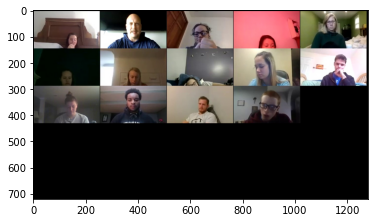

In [83]:
# Import sample images
img0=np.array(Image.open(photo))
plt.imshow(img0)
plt.show()

In [85]:
# Read output json
coordinates_emotions=json.load(open(outputjson_emotion,"r"))

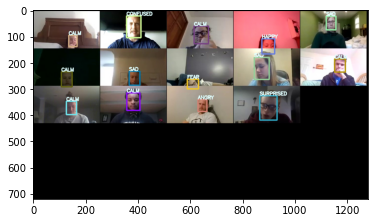

In [79]:
# Inferences
result = img0.copy()
for i,value in enumerate(coordinates_emotions["FaceDetails"]):
    BoundingBox = value["BoundingBox"]
    df=pd.DataFrame(value["Emotions"])
    emotions=dict(zip(list(df["Type"]),list(df["Confidence"])))
    # emotions["Person"]="Ashish"
    label='%s' % (df["Type"].iloc[df['Confidence'].idxmax()])
    tl = round(0.002 * (img0.shape[0] + img0.shape[1]) / 2) + 1  # line/font thickness
    color = [random.randint(0, 255) for _ in range(3)]
    tf = max(tl - 1, 1)  # font thickness
    t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
    x1, y1, w_size, h_size= BoundingBox["Left"], BoundingBox["Top"], BoundingBox["Width"],BoundingBox["Height"]
    x_start = round(x1*img0.shape[1])
    y_start = round(y1*img0.shape[0])
    x_end = round(x_start + w_size*img0.shape[1])
    y_end = round(y_start + h_size*img0.shape[0])
    roi=img0.copy()
    roi = roi[y_start:y_end, x_start:x_end]
    cv2.imwrite(rf"..\db\artifact\Person_{str(i)}.jpg",cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    c1,c2=(x_start, y_start), (x_end, y_end)
    cv2.rectangle(result, c1,c2,color, thickness=tl, lineType=cv2.LINE_AA) 
    cv2.putText(result, label, (c1[0], c1[1] - 2), 0, tl / 5, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
cv2.imwrite(r"..\out\result1.jpg",cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.imshow(result)
plt.show()

# Person Identification

In [87]:
import os
import glob
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
path = r"C:\Users\imash\Documents\upwork"
directory = path+ "/db/artifact/Person_*.jpg"
ArtifactFiles = glob.glob(directory)
PersonName = list(map(lambda x: os.path.split(x)[1].split(".")[0],ArtifactFiles))

In [88]:
def similarity(image_one, image_two):
    """ To find the cosine siilarity between two images """
    # data1 image
    gray_image1 = cv2.cvtColor(cv2.resize(cv2.imread(image_one), (300, 300)), cv2.COLOR_BGR2GRAY) # Read from disk
    # data2 image
    gray_image2 = cv2.cvtColor(cv2.resize(image_two, (300, 300)), cv2.COLOR_BGR2GRAY) # Read from matrics 
    # Cosine similarity
    similarity = cosine_similarity(gray_image1.reshape(1,-1),gray_image2.reshape(1,-1))[0][0]
    # print(f"[info...] Similarity = {similarity}")
    return(similarity)

In [89]:
# ArtifactFiles[0]

In [90]:
# Inferences
result = img0.copy()

for i,value in enumerate(coordinates_emotions["FaceDetails"]):
    BoundingBox = value["BoundingBox"]
    df=pd.DataFrame(value["Emotions"])
    output=dict(zip(list(df["Type"]),list(df["Confidence"])))
    label='%s' % (df["Type"].iloc[df['Confidence'].idxmax()])
    x1, y1, w_size, h_size= BoundingBox["Left"], BoundingBox["Top"], BoundingBox["Width"],BoundingBox["Height"]
    x_start = round(x1*img0.shape[1])
    y_start = round(y1*img0.shape[0])
    x_end = round(x_start + w_size*img0.shape[1])
    y_end = round(y_start + h_size*img0.shape[0])
    roi=img0.copy()
    similarity_score = [similarity(file, cv2.cvtColor(roi[y_start:y_end, x_start:x_end], cv2.COLOR_BGR2RGB)) for file in ArtifactFiles]

    if max(similarity_score) >= 0.95:
        output["Person"]=PersonName[similarity_score.index(max(similarity_score))]
    else:
        output["Person"] = "XXXXX"

    del similarity_score

    print(output)


{'SURPRISED': 50.90237808227539, 'CALM': 33.49756622314453, 'CONFUSED': 10.638799667358398, 'ANGRY': 2.9406943321228027, 'SAD': 0.943838357925415, 'HAPPY': 0.6725127100944519, 'DISGUSTED': 0.25261422991752625, 'FEAR': 0.15160374343395233, 'Person': 'Person_0'}
{'SAD': 84.52983856201172, 'CALM': 12.438765525817871, 'FEAR': 0.8895478248596191, 'CONFUSED': 0.8013002872467041, 'ANGRY': 0.5809783339500427, 'DISGUSTED': 0.3037291467189789, 'HAPPY': 0.28984567523002625, 'SURPRISED': 0.16599003970623016, 'Person': 'Person_1'}
{'CONFUSED': 99.71062469482422, 'ANGRY': 0.09035812318325043, 'DISGUSTED': 0.060393258929252625, 'CALM': 0.0592348575592041, 'SAD': 0.026838652789592743, 'SURPRISED': 0.024828564375638962, 'FEAR': 0.017686577513813972, 'HAPPY': 0.010035349987447262, 'Person': 'Person_2'}
{'CALM': 61.42258071899414, 'HAPPY': 24.916471481323242, 'SURPRISED': 5.1093621253967285, 'FEAR': 2.3200249671936035, 'SAD': 2.3029563426971436, 'CONFUSED': 2.149034023284912, 'DISGUSTED': 0.9756540656089